# Investigating Variable Renaming

In [2]:
import torch
import numpy as np
import seaborn as sns

from iluvattnshun.utils import load_checkpoint, load_config_from_yaml
from iluvattnshun.nn import MultilayerTransformer
from iluvattnshun.viz import get_fig
from matplotlib import pyplot as plt
from torch.nn.functional import cosine_similarity

from train import VariableRenamingConfig, VariableRenamingPrompter

In [3]:
# 5 layers, 2 heads
config_path = "configs/l5h2_config.yaml"
ckpt_path = "checkpoints/l5h2_ckpt_epoch_308.pt"

config = load_config_from_yaml(config_path, VariableRenamingConfig)

# loading the model
max_seq_len = config.num_renames * 4
model = MultilayerTransformer(
    vocab_size=39,
    d_model=config.dim_model,
    n_heads=config.num_heads,
    n_layers=config.num_layers,
)
load_checkpoint(ckpt_path, model)
model.eval()

# loading the prompter
prompter = VariableRenamingPrompter(config)

In [4]:

def predict(model, seed, verbose=True):
    """Predicts the next token given an input tensor."""

    rng = np.random.default_rng(seed)
    prompt, answer, metadata = prompter.get_prompt(rng)
    x = torch.tensor(prompter.tokenize(prompt)).unsqueeze(0)

    logits, kv_cache, attn_weights, xs = model.forward(x, return_new_kv_cache=True, return_attn_weights=True, return_xs=True)
    pred = prompter.detokenize(logits[0].argmax(dim=-1).tolist())
    right = "".join(["✔" if pred[i] == answer[i] else ("." if i % 2 == 1 else "✖") for i in range(len(pred))]).strip()
    depth_0 = "".join([str(d)[0] for d in metadata["depths"]])
    depth_1 = "".join([str(d)[1] if len(str(d)) == 2 else " " for d in metadata["depths"]])
    accuracy = right.count("✔") / (len(answer) // 2)

    if verbose:
        print("Model: ", config_path.split("/")[-2])
        print("Checkpoint: ", ckpt_path.split("/")[-1])
        print("Answer:   ", answer)
        print("Prompt:   ", prompt)
        print("Predicted:", pred)
        print("Right:    ", right)
        print("Depth 0:  ", depth_0)
        print("Depth 1:  ", depth_1)
        print("Accuracy: ", accuracy)

    return prompt, logits, kv_cache, attn_weights, xs, accuracy



prompt, logits, kv_cache, attn_weights, xs, accuracy = predict(model, 42)

Model:  configs
Checkpoint:  l5h2_ckpt_epoch_308.pt
Answer:    2.2.0.0.1.1.3.3.0.0.0.0.0.0.3.3.2.2.2.2.0.0.1.1.0.0.2.2.3.3.1.1.3.3.0.0.1.1.0.0.2.2.0.0.0.0.0.0.3.3.2.2.3.3.3.3.1.1.1.1.0.0.2.2.2.2.2.2.3.3.3.3.2.2.3.3.1.1.2.2.0.0.1.1.2.2.0.0.0.0.2.2.2.2.1.1.3.3.3.3.3.3.0.0.1.1.1.1.0.0.2.2.1.1.3.3.3.3.1.1.2.2.1.1.0.0.1.1.1.1.1.1.2.2.3.3.2.2.3.3.2.2.0.0.3.3.3.3.2.2.2.2.1.1.1.1.0.0.1.1.2.2.0.0.3.3.3.3.3.3.1.1.2.2.3.3.1.1.3.3.1.1.2.2.2.2.2.2.1.1.2.2.3.3.3.3.0.0.0.0.1.1.2.2.0.0.0.0.1.1.2.2.2.2.3.3.0.0.2.2.3.3.2.2.1.1.3.3.0.0.0.0.1.1.2.2.1.1.1.1.1.1.3.3.2.2.3.3.2.2.2.2.3.3.3.3.1.1.3.3.0.0.1.1.2.2.1.1.3.3.0.0.2.2.0.0.3.3.2.2.2.2.0.0.1.1.2.2.2.2.2.2.1.1.2.2.3.3.0.0.
Prompt:    2>l;0>c;1>f;3>p;c>u;u>s;s>n;p>w;l>o;o>e;n>u;f>k;u>n;e>l;w>c;k>x;c>v;n>g;x>d;g>s;l>b;s>l;l>r;r>t;v>k;b>n;k>p;p>u;d>y;y>i;t>k;n>x;x>b;b>v;u>m;m>s;v>h;s>p;i>y;h>d;k>q;y>c;d>u;q>k;k>w;u>x;x>g;c>r;p>v;v>t;t>u;w>t;r>l;l>h;t>o;g>n;h>a;u>g;g>l;a>s;n>w;s>b;o>p;b>o;o>b;b>u;w>o;l>h;o>z;h>g;z>y;p>a;g>v;v>t;y>x;x>k;u>d;d>o;a>z;o>j;k>l;z

## Token Embeddings

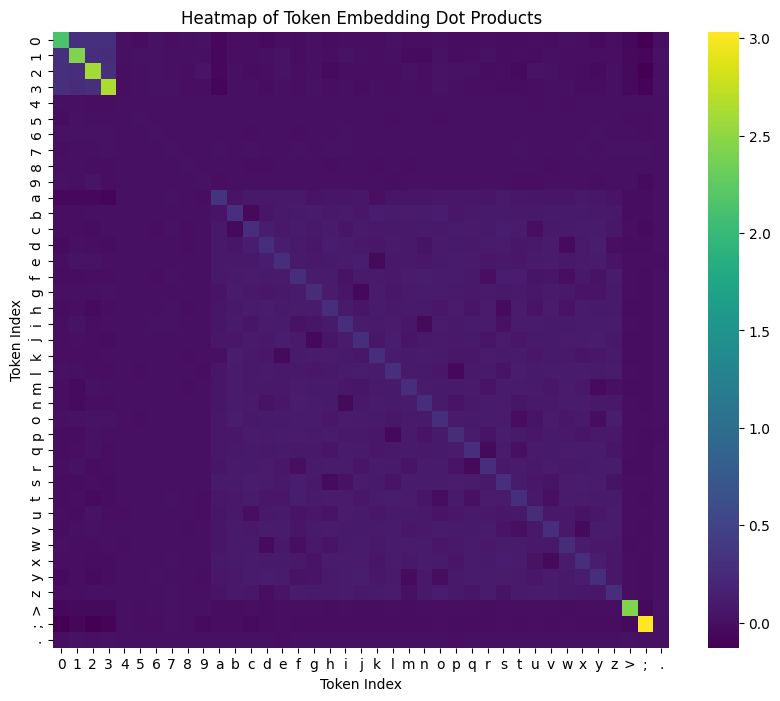

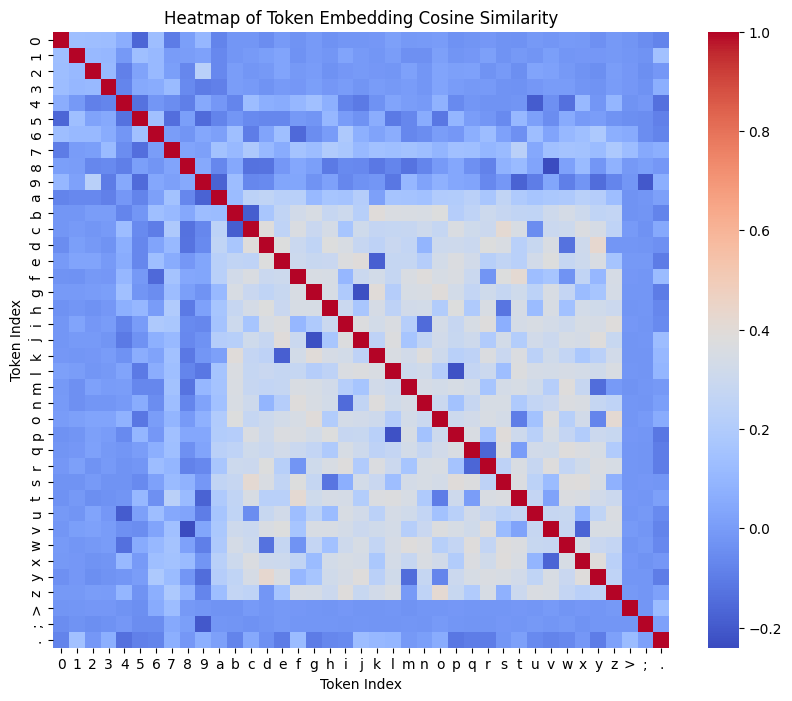

In [5]:
token_embeddings = model.token_embedding.weight.detach().cpu()  # Shape: (vocab_size, d_model)
labels = prompter.detokenize(list(range(39)))  # This will give you the token labels
dot_products = torch.matmul(token_embeddings, token_embeddings.T)  # Shape: (vocab_size, vocab_size)
cos_sim = cosine_similarity(token_embeddings.unsqueeze(0), token_embeddings.unsqueeze(1), dim=-1).squeeze(0)

plt.figure(figsize=(10, 8))
sns.heatmap(dot_products.numpy(), cmap="viridis", square=True, xticklabels=labels, yticklabels=labels)
plt.title("Heatmap of Token Embedding Dot Products")
plt.xlabel("Token Index")
plt.ylabel("Token Index")
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim.numpy(), cmap="coolwarm", square=True, xticklabels=labels, yticklabels=labels)
plt.title("Heatmap of Token Embedding Cosine Similarity")
plt.xlabel("Token Index")
plt.ylabel("Token Index")
plt.show()

## Attention Weights

### Layer 1

In [6]:
weights = [attn_weight.detach().cpu().numpy()[0] for attn_weight in attn_weights]
plotly_fig = get_fig(weights, list(prompt), base_height=800, selected_layers=[0], selected_heads=[0, 1], selected_x_toks=list(range(100)), selected_y_toks=list(range(100)))
plotly_fig.write_html("assets/l1_attn_map.html")
plotly_fig.show()

### Layer 2

In [7]:
weights = [attn_weight.detach().cpu().numpy()[0] for attn_weight in attn_weights]
plotly_fig = get_fig(weights, list(prompt), base_height=800, selected_layers=[1], selected_heads=[0, 1], selected_x_toks=list(range(100)), selected_y_toks=list(range(100)))
plotly_fig.write_html("assets/l2_attn_map.html")
plotly_fig.show()

- Head 1 seems to just average everything with a slight bias toward `>`. While useful information could be extracted
  from this, we'll focus on the much more interesting head 2 from here on out.
- In scenarios where `a>b;...;b>c`, the second `b` will commonly attend to `a`, and the second `>` and `c` will attend
  to the most recent `b`. (TODO: think about how the second `b` finds `a` since the first `b` presumably does not attend to `a` according to the previous layer.)
- In some cases where variables are renamed immediately after their assignment (e.g. see `c>u;u` or `l>o;o`) multiple
  elements beyond the second `u` and `o` will attend to `c` and `l` respectively. This is likely because, in L1H1, the
  `u` and `o` tokens already attended to their previous selves.

### Layer 3

In [8]:
weights = [attn_weight.detach().cpu().numpy()[0] for attn_weight in attn_weights]
plotly_fig = get_fig(weights, list(prompt), base_height=800, selected_layers=[2], selected_heads=[0, 1], selected_x_toks=list(range(100)), selected_y_toks=list(range(100)))
plotly_fig.write_html("assets/l3_attn_map.html")
plotly_fig.show()

### Layer 4

In [9]:
weights = [attn_weight.detach().cpu().numpy()[0] for attn_weight in attn_weights]
plotly_fig = get_fig(weights, list(prompt), base_height=800, selected_layers=[3], selected_heads=[0, 1], selected_x_toks=list(range(100)), selected_y_toks=list(range(100)))
plotly_fig.write_html("assets/l4_attn_map.html")
plotly_fig.show()

### Layer 5

In [12]:
weights = [attn_weight.detach().cpu().numpy()[0] for attn_weight in attn_weights]
plotly_fig = get_fig(weights, list(prompt), base_height=800, selected_layers=[4], selected_heads=[0, 1], selected_x_toks=list(range(100)), selected_y_toks=list(range(100)))
plotly_fig.write_html("assets/l5_attn_map.html")
plotly_fig.show()

In [13]:
weights = [attn_weight.detach().cpu().numpy()[0] for attn_weight in attn_weights]
plotly_fig = get_fig(weights, list(prompt), base_height=800, selected_layers=[4], selected_heads=[0, 1], selected_x_toks=list(range(400, 500)), selected_y_toks=list(range(400, 500)))
plotly_fig.write_html("assets/l5_attn_map_400_550.html")
plotly_fig.show()

## Attention Patching

In [14]:
_, _, _, fake_attn_weights, _, _ = predict(model, 420)

Model:  configs
Checkpoint:  l5h2_ckpt_epoch_308.pt
Answer:   

 0.0.0.0.3.3.2.2.0.0.1.1.3.3.2.2.1.1.3.3.0.0.1.1.2.2.1.1.3.3.0.0.2.2.1.1.0.0.0.0.3.3.2.2.1.1.0.0.1.1.1.1.3.3.0.0.3.3.1.1.1.1.2.2.3.3.2.2.0.0.3.3.0.0.3.3.1.1.1.1.0.0.0.0.1.1.0.0.0.0.3.3.1.1.3.3.2.2.3.3.1.1.1.1.1.1.1.1.3.3.2.2.2.2.0.0.0.0.2.2.0.0.0.0.2.2.0.0.1.1.0.0.1.1.1.1.1.1.1.1.1.1.3.3.0.0.0.0.3.3.3.3.3.3.0.0.2.2.3.3.2.2.2.2.0.0.3.3.1.1.2.2.0.0.1.1.3.3.3.3.3.3.2.2.1.1.3.3.1.1.2.2.0.0.0.0.3.3.2.2.1.1.1.1.1.1.1.1.0.0.0.0.2.2.1.1.2.2.3.3.0.0.1.1.2.2.2.2.3.3.2.2.0.0.0.0.2.2.1.1.0.0.1.1.1.1.2.2.0.0.3.3.1.1.1.1.2.2.3.3.0.0.2.2.3.3.2.2.3.3.0.0.0.0.1.1.3.3.2.2.3.3.1.1.0.0.0.0.1.1.0.0.0.0.2.2.3.3.0.0.
Prompt:    0>w;w>a;3>k;2>r;a>q;1>p;k>d;r>f;p>n;d>x;q>b;n>g;f>u;g>p;x>s;b>f;u>i;p>u;f>v;v>c;s>w;i>l;u>k;c>o;k>m;m>g;w>x;o>w;x>f;g>y;y>e;l>o;f>h;o>n;w>t;h>b;t>v;b>p;e>c;c>h;v>l;l>w;h>s;w>e;e>z;p>t;s>p;t>g;n>q;g>n;p>o;o>p;p>f;f>t;n>b;q>f;f>w;z>y;y>z;w>v;z>j;j>h;v>y;h>s;t>r;s>w;r>x;x>z;z>n;n>f;f>u;b>s;w>x;x>k;s>h;h>g;g>b;k>a;y>k;b>w;k>s;s>f;a>z;w>b;u>e;f>t;z>x;e>z;b>k;k>l;l>q;t>o;z>e;q>n;e>j;o>s;x>m

In [15]:
def patch_attention_map(attn_map, layer_idx, head_idx):
    """
    Patch the attention weights based on the specified patch type.
    """
    patch_map = fake_attn_weights[layer_idx][0, head_idx].clone()
    attn_map[0, head_idx] = patch_map / patch_map.sum(dim=-1, keepdim=True)  # Normalize the attention map
    return attn_map

In [16]:
for i in range(5):
    for j in range(2):
        model.layers[i].attention.attn_weights_override = lambda x: patch_attention_map(x, i, j)
        _, logits, kv_cache, attn_weights, xs, accuracy = predict(model, 42, verbose=False)
        model.layers[i].attention.attn_weights_override = None
        print(f"Patching Layer {i+1}, Head {j} - Accuracy: {accuracy:.4f}")
    print("\n")

Patching Layer 1, Head 0 - Accuracy: 0.2367
Patching Layer 1, Head 1 - Accuracy: 0.2467


Patching Layer 2, Head 0 - Accuracy: 0.5100
Patching Layer 2, Head 1 - Accuracy: 0.2033


Patching Layer 3, Head 0 - Accuracy: 0.5900
Patching Layer 3, Head 1 - Accuracy: 0.3400


Patching Layer 4, Head 0 - Accuracy: 0.3000
Patching Layer 4, Head 1 - Accuracy: 0.8767


Patching Layer 5, Head 0 - Accuracy: 0.8700
Patching Layer 5, Head 1 - Accuracy: 0.5100


